In [1]:
import numpy as np
import ctypes, time, os
import sys
import nibabel as nib

# Import popeye stuff
import popeye.utilities_cclab as utils
from popeye.visual_stimulus import VisualStimulus
# import popeye.models_cclab as prfModels
# import popeye.css_cclab as prfModels

# Import multiprocessing stuff
import multiprocessing as mp
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
from itertools import product

# Load helper functions
from helpersSurface import set_paths_surface, load_stimuli, averageRuns, save2gifti
from fit_utils import *
from fitutils_css_Surface import *
import ctypes
plt.style.use('dark_background')
%load_ext autoreload
%autoreload 2

zod


In [2]:
print('Initializing parameters ...')
codeStartTime = time.perf_counter()
params = {}
params['subjID'] = 'MAM0606'
# Got these from Zhengang, and he got it from rsvp_params.txt
params['viewingDistance'] = 83.5 #63 #83.5 # in cm
params['screenWidth'] = 36.2 #35 #36.2 # in cm
params['scaleFactor'] = 1
params['resampleFactor'] = 1
params['dtype'] = ctypes.c_int16

p, funcFiles = set_paths_surface(params)

# Load stimulus
bar, _ = load_stimuli(p)
# bar = bar[:, :, 0:201]
# Mirror y axis (this is done because popeye flips the y axis)
bar = np.flip(bar, axis=0)

# Average runs and get metadata
leftDataOrig, rightDataOrig, tr_length, nTRs = averageRuns(p, funcFiles)
params['tr_length'] = tr_length
params['nTRs'] = nTRs

# load scan data
print('Detrending scan data ...')
leftDataOrigDetrended = remove_trend(leftDataOrig, method='all')
rightDataOrigDetrended = remove_trend(rightDataOrig, method='all')

print('Creating stimulus object ...')
stimulus = VisualStimulus(bar.astype('int16'),
                        params['viewingDistance'],
                        params['screenWidth'],
                        params['scaleFactor'],
                        params['tr_length'],
                        params['dtype'],
)


Initializing parameters ...
Loading average data from disk
Detrending scan data ...
Creating stimulus object ...


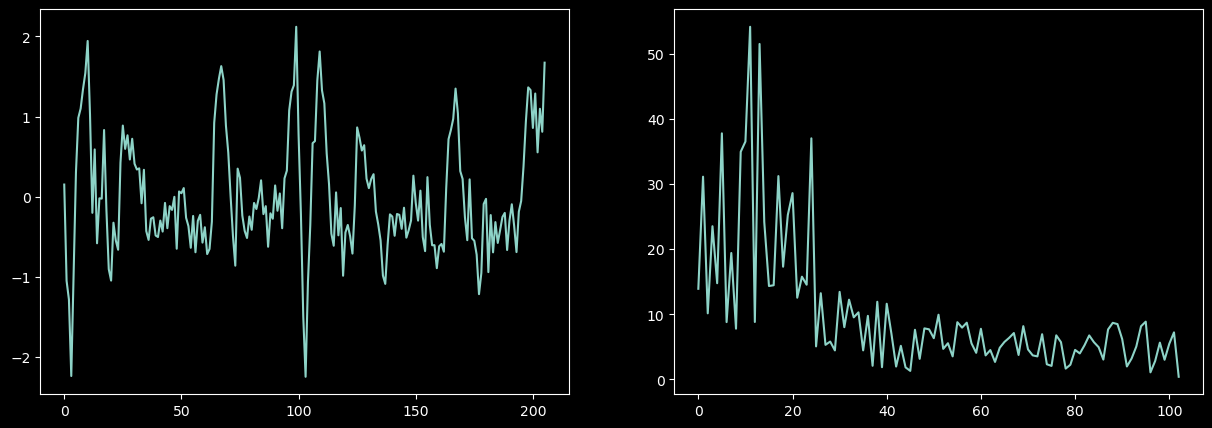

In [3]:
# leftDataOrigFFT = np.zeros((leftDataOrig.shape[0], leftDataOrig[:, 5:].shape[1] // 2 + 1), dtype=complex)
rightDataFFT = np.zeros((rightDataOrigDetrended.shape[0], rightDataOrigDetrended[:, 5:].shape[1] // 2 + 1), dtype=complex)
for ivtx in range(rightDataOrigDetrended.shape[0]):
    thData = rightDataOrigDetrended[ivtx, 5:] 
    thData = (thData - np.mean(thData)) / np.std(thData) 
    rightDataFFT[ivtx, :] = np.fft.rfft(thData)

f, axs = plt.subplots(1, 2, figsize=(15, 5))
voxNum = np.random.randint(0, rightDataOrigDetrended.shape[0])
axs[0].plot(rightDataOrigDetrended[voxNum, 5:])
axs[1].plot(np.abs(rightDataFFT[voxNum, 1:]))
plt.show()

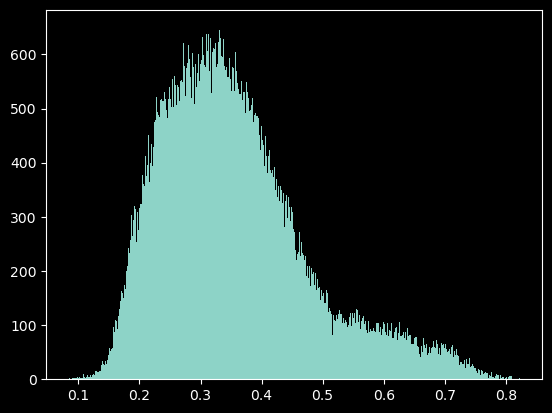

In [4]:
lowFreqPow = []
for ivtx in range(rightDataOrigDetrended.shape[0]):
    thData = rightDataFFT[ivtx, 1:20]
    # thData = (thData - np.mean(thData)) / np.std(thData) 
    lowFreqPow.append(np.sum(np.abs(thData)) / np.sum(np.abs(rightDataFFT[ivtx, 1:])))
lowFreqPow = np.array(lowFreqPow)
plt.hist(lowFreqPow, bins=1000)
plt.show()

Quantile edges: [0.08447738 0.26682263 0.33754009 0.42008568 0.82277287]


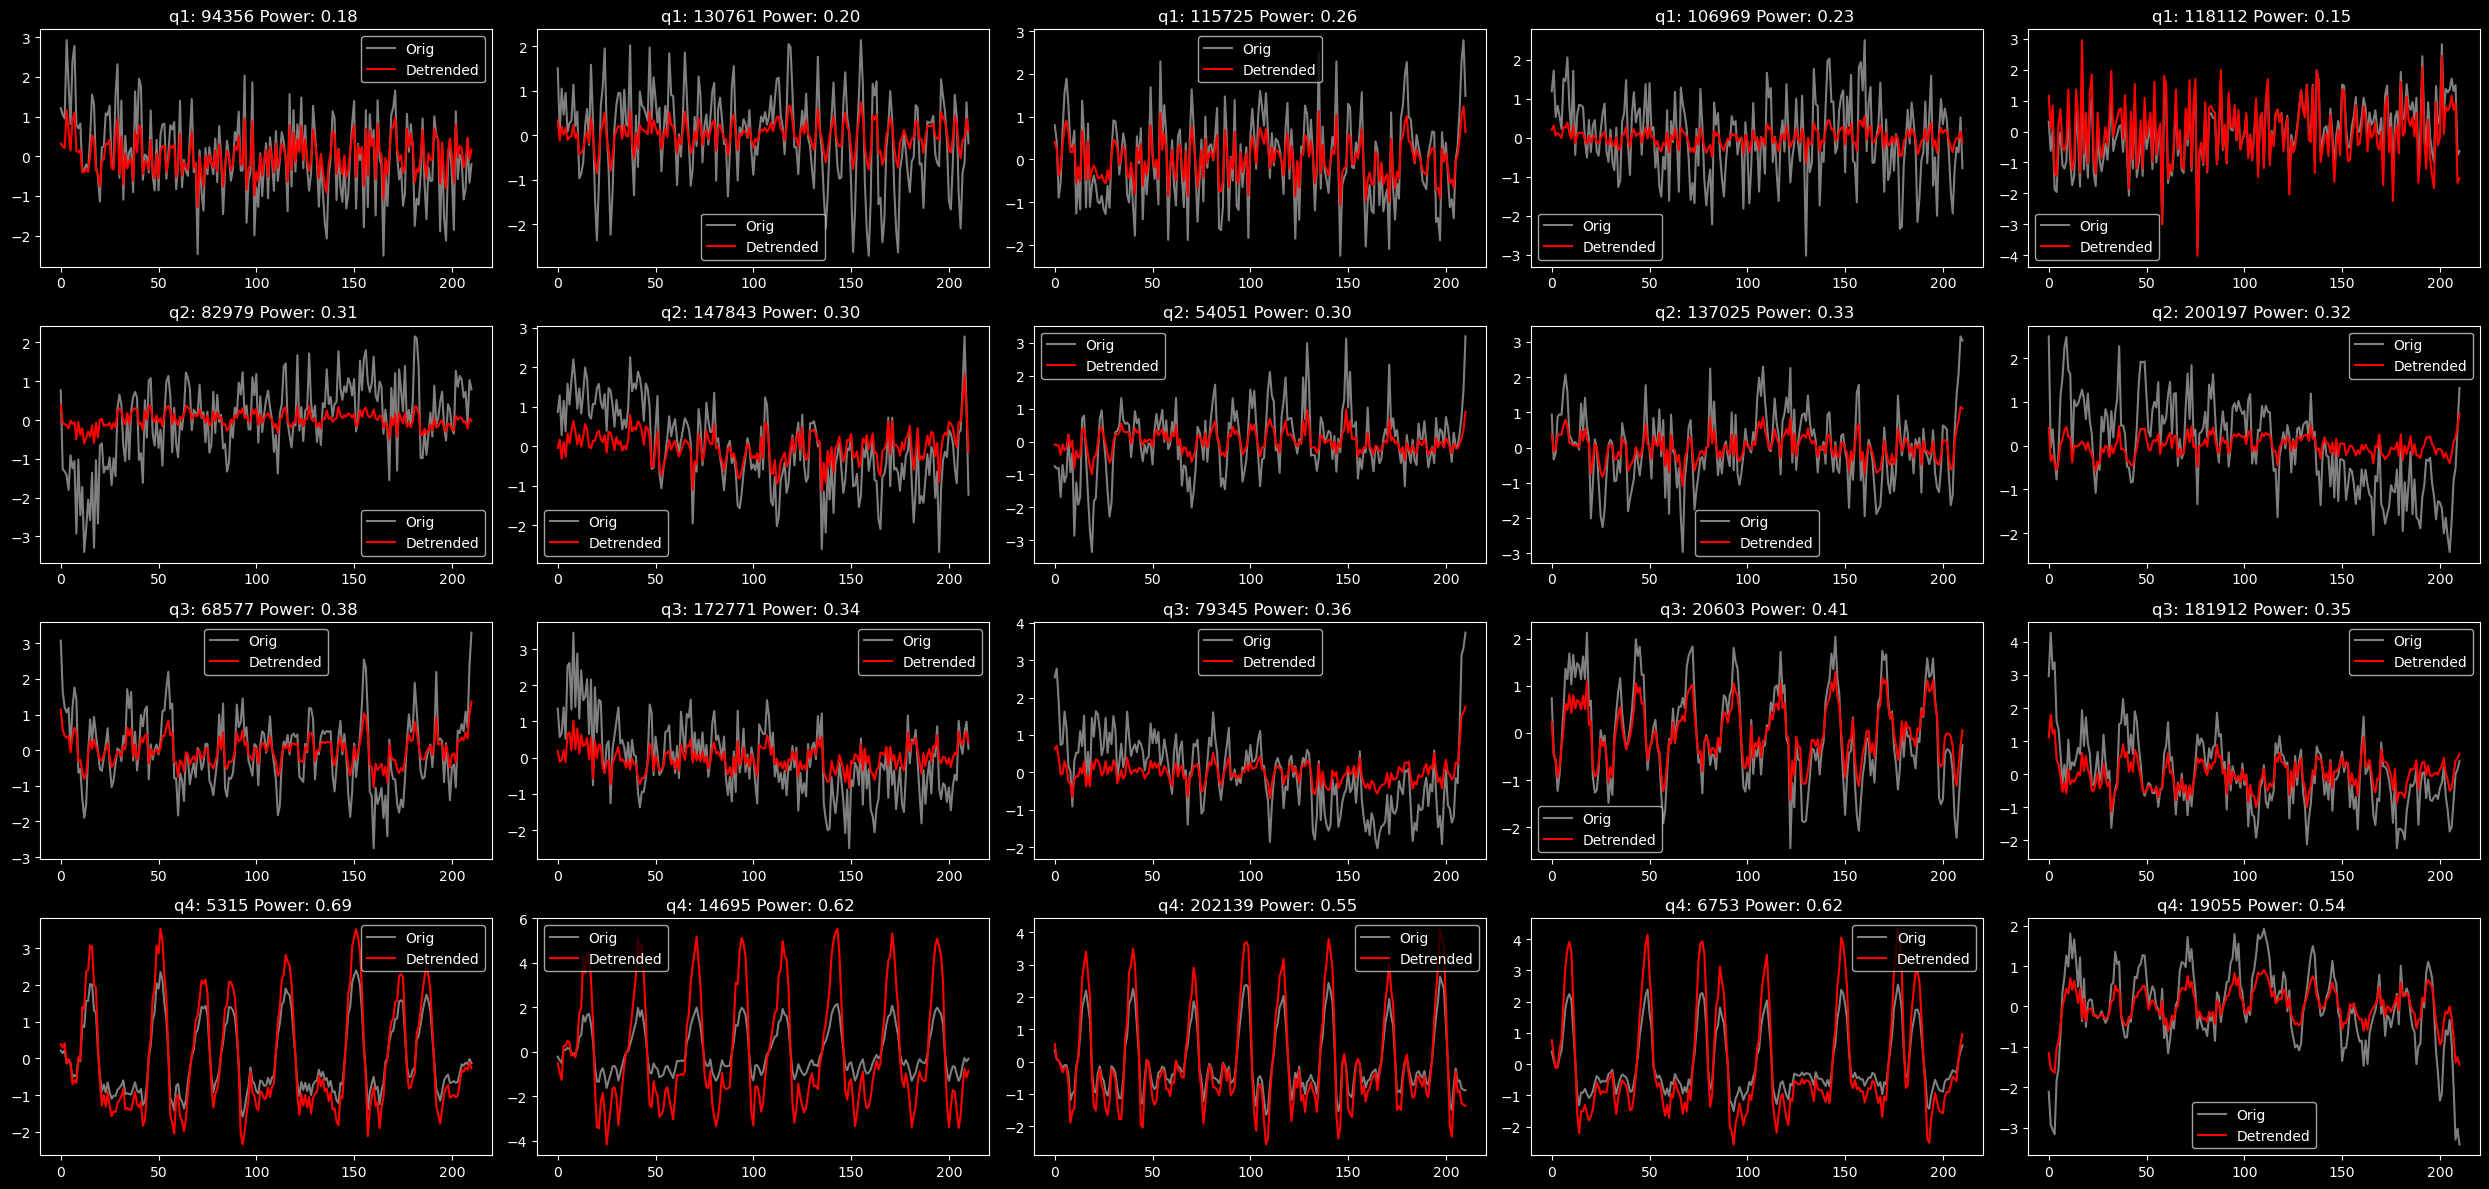

In [5]:
# Set number of quantiles and vertices per quantile to plot
n_quantiles = 4   # e.g., quartiles=4, quintiles=5, etc.
nVtx = 5

# Compute quantile edges
quantile_edges = np.percentile(lowFreqPow, np.linspace(0, 100, n_quantiles+1))
print('Quantile edges:', quantile_edges)

# Get indices for each quantile
quantile_indices = []
for i in range(n_quantiles):
    if i < n_quantiles - 1:
        idx = np.where((lowFreqPow >= quantile_edges[i]) & (lowFreqPow < quantile_edges[i+1]))[0]
    else:
        idx = np.where((lowFreqPow >= 0.5))[0]
    #     # Include the upper edge in the last quantile
    #     idx = np.where((lowFreqPow >= quantile_edges[i]) & (lowFreqPow <= quantile_edges[i+1]))[0]
    quantile_indices.append(idx)

# Prepare figure
fig, axs = plt.subplots(n_quantiles, nVtx, figsize=(5*nVtx, 3*n_quantiles), squeeze=False)

for q in range(n_quantiles):
    for i in range(nVtx):
        if len(quantile_indices[q]) == 0:
            continue  # skip empty quantiles
        vtx = np.random.choice(quantile_indices[q], 1)[0]
        origThis = (rightDataOrig[vtx, :] - np.mean(rightDataOrig[vtx, :])) / np.std(rightDataOrig[vtx, :])
        axs[q, i].plot(origThis, 'w', label='Orig', alpha=0.5)
        axs[q, i].plot(rightDataOrigDetrended[vtx, :], 'r', label='Detrended')
        axs[q, i].legend()
        axs[q, i].set_title(f'q{q+1}: {vtx} Power: {lowFreqPow[vtx]:.2f} ')
        # axs[q, i].set_ylim([-2, 2])

plt.tight_layout()
plt.show()

In [6]:
print(len(quantile_indices[-1]))

27786


In [7]:
gridEstimfPath = '/d/DATD/datd/popeye_pRF/sub-MAM0606/popeyeFit/fitEstimatesOrig/RF_ss5_gFit_popeye_right.func.gii'
gridEstimF = nib.load(gridEstimfPath) #np.array([x.data for x in imgLeft.darrays]).T
gridEstimData = np.array([x.data for x in gridEstimF.darrays]).T # (theta, r2, rho, s, n, x, y, betas[1], betas[0])

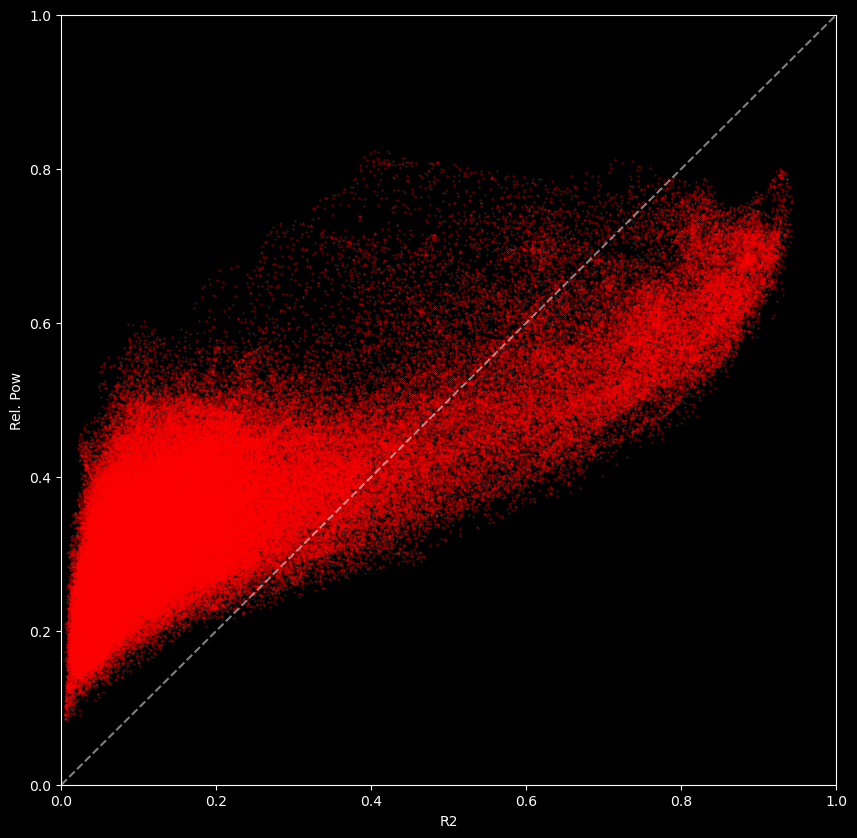

In [8]:
plt.figure(figsize=(10, 10))
plt.plot(gridEstimData[:, 1], lowFreqPow, 'ro', markersize=0.25)
plt.plot([0, 1], [0, 1], 'w--', alpha=0.5)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('R2')
plt.ylabel('Rel. Pow')
plt.show()

In [ ]:
relevIdx = quantile_indices[-1]#[:1000]

rightData = rightDataOrigDetrended[relevIdx, :]
Ns = 15
x_grid = np.concatenate((np.linspace(-stimulus.deg_x0.max(), stimulus.deg_x0.max(), Ns//2),
                        np.geomspace(-stimulus.deg_x0.max(), -2*stimulus.deg_x0.max(), Ns//4),
                        np.geomspace(stimulus.deg_x0.max(), 2*stimulus.deg_x0.max(), Ns//4)))
y_grid = np.concatenate((np.linspace(-stimulus.deg_y0.max(), stimulus.deg_y0.max(), Ns//2),
                        np.geomspace(-stimulus.deg_y0.max(), -2*stimulus.deg_y0.max(), Ns//4),
                        np.geomspace(stimulus.deg_y0.max(), 2*stimulus.deg_y0.max(), Ns//4)))
s_grid = np.concatenate((np.linspace(0.1, 5, 3*Ns//4), np.geomspace(5, stimulus.deg_x0.max(), Ns//4)))
n_grid = np.asarray([0.25, 0.5, 0.75, 1])
grid_space_orig = list(product(x_grid, y_grid, s_grid, n_grid))
grid_space = constraint_grids(grid_space_orig, stimulus)
print(f'Number of grid points: {len(grid_space)}')

param_width = [np.mean(np.diff(x_grid)), np.mean(np.diff(y_grid)), np.mean(np.diff(s_grid)), np.mean(np.diff(n_grid))]
# param_width = np.asarray(round(param_width, 4))

tstamp_start = time.perf_counter()

############################  GRID PREDICTIONS ################################
if Ns == 25:
    gridPath = p['gridfit_path_25']
elif Ns == 35:
    gridPath = p['gridfit_path_35']
elif Ns == 50:
    gridPath = p['gridfit_path_50']
else:
    gridPath = os.path.join(p['stimuli_path'], 'gridfit_' + str(Ns) + '.npy')

if os.path.exists(gridPath):
    print("Loading grid predictions from disk")
    grid_preds = np.load(gridPath)
else:
    print("Grid predictions don't exist. Generating them")
    grid_preds = getGridPreds(grid_space, stimulus, gridPath, nTRs)

tstamp_gridpred = time.perf_counter()
# print(f'Obtained grid predictions in {tstamp_gridpred-tstamp_start} seconds')
print_time(tstamp_start, tstamp_gridpred, 'Grid predictions')

############################  GRID FIT ################################

if os.path.exists(os.path.join(p['fitEstimDir'], 'RF_ss5_gFit_popeye_left.func.gii')):
    print("Loading grid estimates from disk")
    # RF_left_gFit_img = nib.load(os.path.join(p['fitEstimDir'], 'RF_ss5_gFit_popeye_left.func.gii'))
    # RF_left_gFit = np.array([x.data for x in RF_left_gFit_img.darrays]).T
    # print(RF_left_gFit.shape)
    RF_right_gFit_img = nib.load(os.path.join(p['fitEstimDir'], 'RF_ss5_gFit_popeye_right.func.gii'))
    RF_right_gFit = np.array([x.data for x in RF_right_gFit_img.darrays]).T
    print(RF_right_gFit.shape)
else:
    print('Starting grid fit ...')
    # RF_left_gFit = np.empty((leftDataOrig.shape[0], 9))
    RF_right_gFit = np.empty((rightDataOrigDetrended.shape[0], 9))
    # RF_left_gFit = get_grid_estims(grid_preds, grid_space, leftData, RF_left_gFit, indicesLeft)
    RF_right_gFit = get_grid_estims(grid_preds, grid_space, rightData, RF_right_gFit, relevIdx)
    tstamp_gridestim = time.perf_counter()
    print(f'Obtained grid estimates in {tstamp_gridestim-tstamp_gridpred} seconds')
    print_time(tstamp_gridpred, tstamp_gridestim, 'Grid fit1')


Number of grid points: 4936
Grid predictions don't exist. Generating them
Starting prediction generation
Grid predictions took 12.17 seconds
Starting grid fit ...


 61%|██████    | 16831/27786 [20:59<15:53, 11.49it/s]  

In [ ]:
# tempIdx = relevIdx#[:100]
# rtDataTemp = rightDataOrigDetrended[tempIdx, :]
print('Starting final fit ...')
# RF_left_fFit = np.empty((leftDataOrig.shape[0], 9))
RF_right_fFit = np.empty((rightDataOrigDetrended.shape[0], 9))
# RF_left_fFit = get_final_estims(RF_left_gFit, param_width, leftData, stimulus, RF_left_fFit, indicesLeft)
RF_right_fFit = get_final_estims(RF_right_gFit, param_width, rightData, stimulus, RF_right_fFit, relevIdx)
tstamp_finalestim = time.perf_counter()
print(f'Obtained final estimates in {tstamp_finalestim-tstamp_gridestim} seconds')
print_time(tstamp_gridestim, tstamp_finalestim, 'Final fit')

Starting final fit ...


100%|██████████| 1000/1000 [05:13<00:00,  3.19it/s]

Obtained final estimates in 549.5695450839121 seconds
Final fit took 9 minutes and 10 seconds


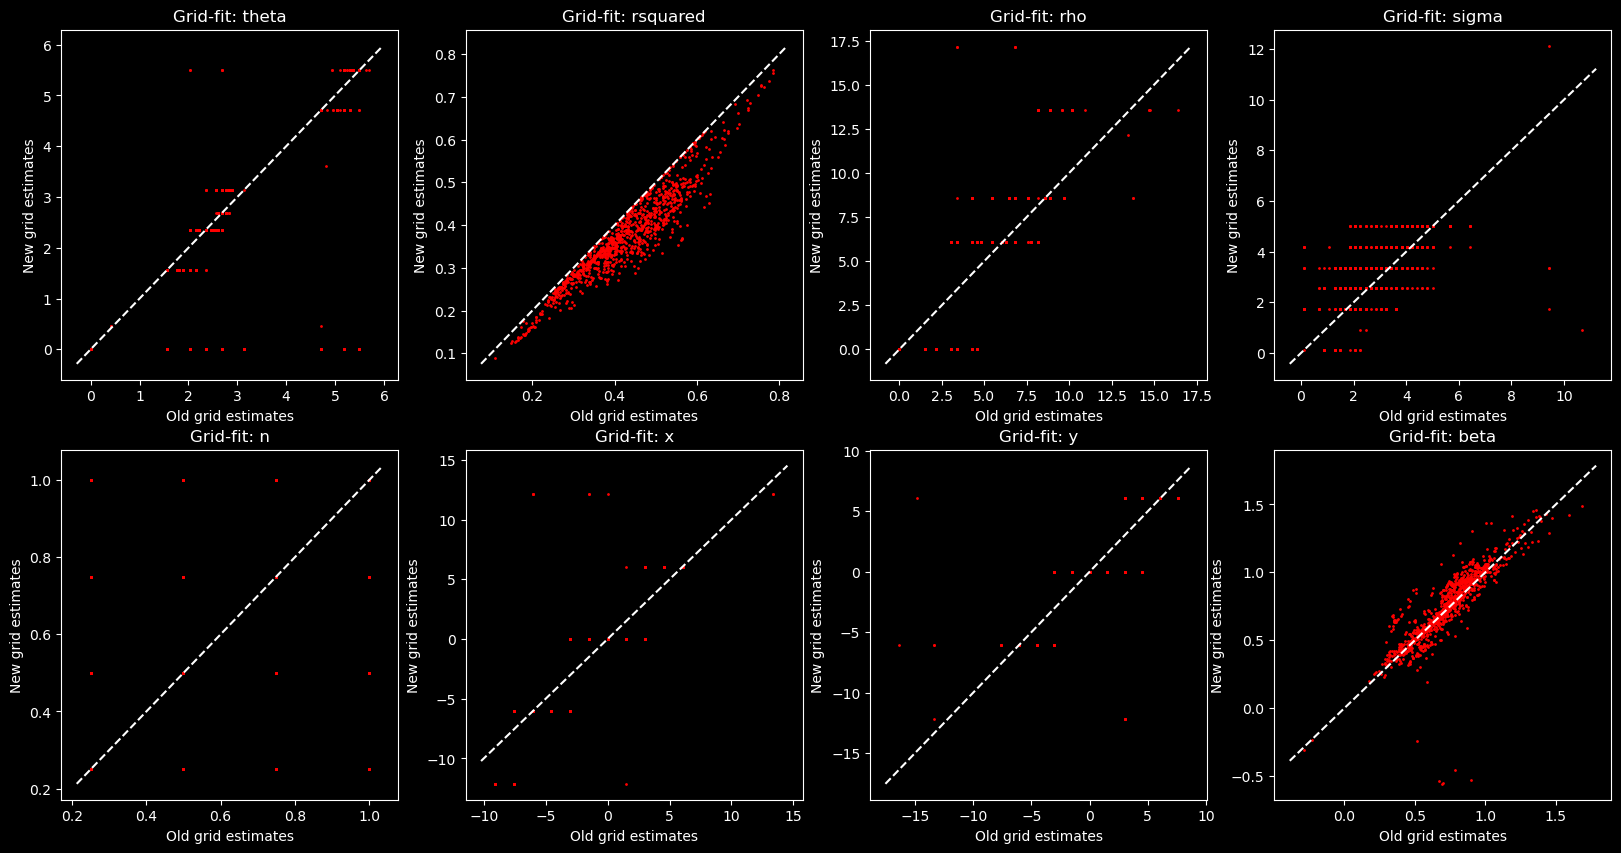

In [17]:
f1, axs = plt.subplots(2, 4, figsize=(20, 10))
axs = axs.flatten()
for i in range(8):
    ax = axs[i]
    # ax.plot(RF_right_gFit[relevIdx, i].flatten(), gridEstimData[relevIdx, i].flatten(), 'ro', markersize=1)
    ax.plot(gridEstimData[relevIdx, i].flatten(), RF_right_gFit[relevIdx, i].flatten(), 'ro', markersize=1)
    ax.plot(ax.get_xlim(), ax.get_xlim(), 'w--')
    ax.set_title(f"Grid-fit: {['theta', 'rsquared', 'rho', 'sigma','n', 'x', 'y', 'beta'][i]}")
    ax.set_xlabel('Old grid estimates')
    ax.set_ylabel('New grid estimates')
plt.show()

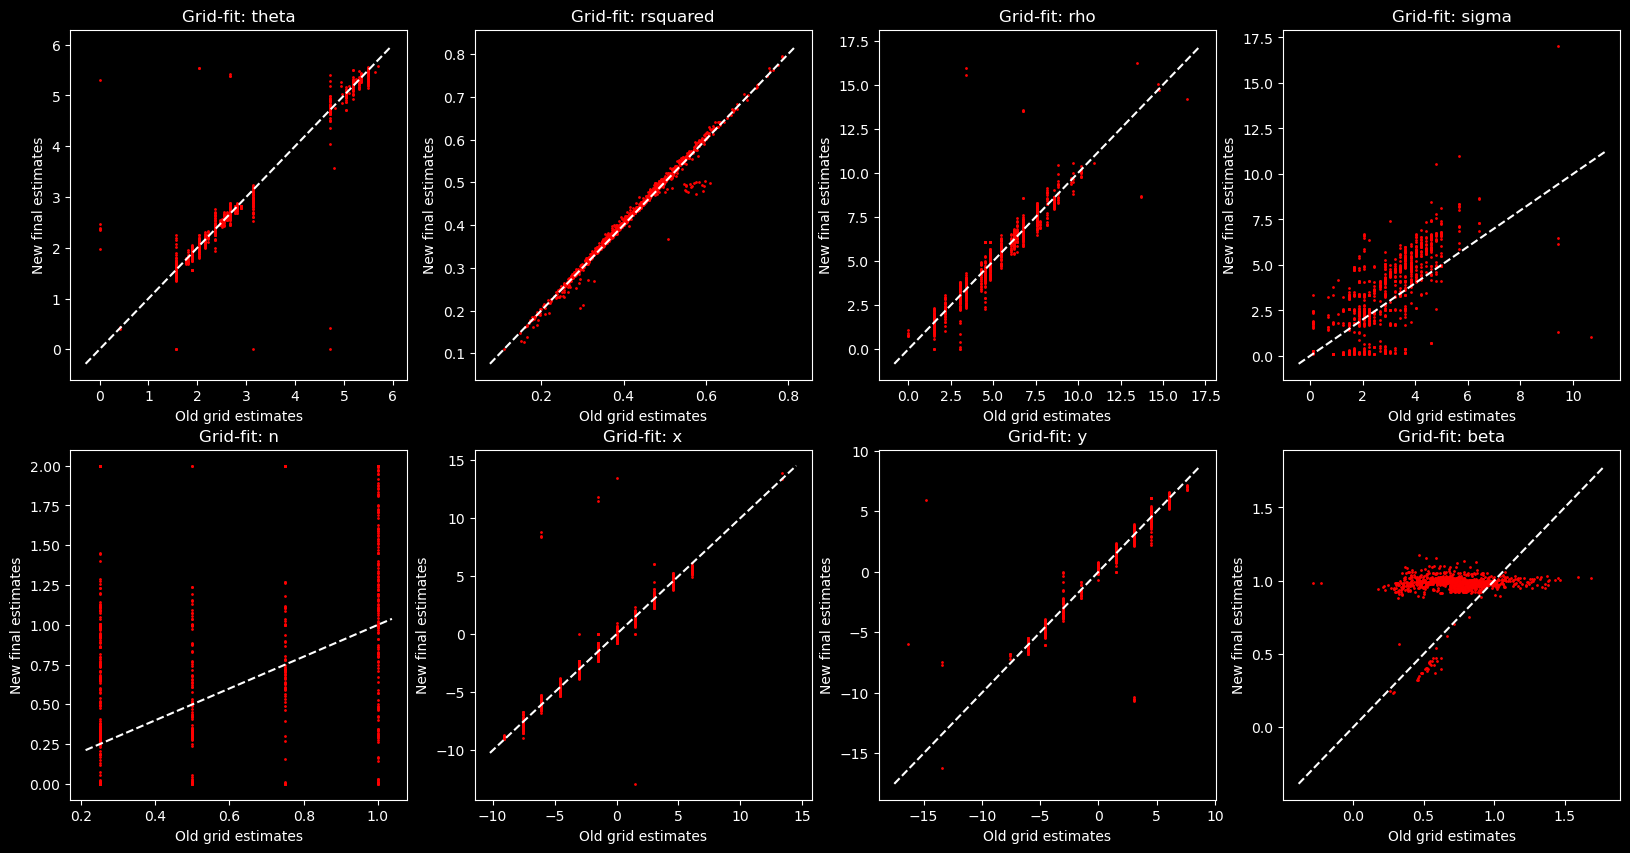

In [18]:
f1, axs = plt.subplots(2, 4, figsize=(20, 10))
axs = axs.flatten()
for i in range(8):
    ax = axs[i]
    ax.plot(gridEstimData[relevIdx, i].flatten(), RF_right_fFit[relevIdx, i].flatten(), 'ro', markersize=1)
    ax.plot(ax.get_xlim(), ax.get_xlim(), 'w--')
    ax.set_title(f"Grid-fit: {['theta', 'rsquared', 'rho', 'sigma','n', 'x', 'y', 'beta'][i]}")
    ax.set_xlabel('Old grid estimates')
    ax.set_ylabel('New final estimates')
plt.show()